# Modelling Rogue Wave Data with Random Forest Classification Model

In [1]:
%load_ext autoreload
%autoreload 2

## Setup
### Imports

Importing all required packages and define seed and number of cores to use.

In [ ]:
import os
import sys
import pickle
import pandas as pd
import numpy as np

sys.path.append('./')
import utils

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap
## Import the Forest-Guided Clustering package
from fgclustering import (
    forest_guided_clustering,
    forest_guided_feature_importance,
    plot_forest_guided_feature_importance,
    plot_forest_guided_decision_paths,
    DistanceRandomForestProximity,
    ClusteringKMedoids,
)

# import warnings
# warnings.filterwarnings("ignore")

### Parameter Settings

In [3]:
seed = 42
n_jobs = 4
print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

Using 4 cores from 8 available cores.


In [4]:
undersample = True
num_cv = 5
case = 2

## Building an ElasticNet Classification Model

### Instantiating the Model and Setting Hyperparameters

- `C`: Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- `l1_ratio`: The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.
- `class_weight`: Weights associated with classes. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

In [5]:
hyperparameter_grid = {'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 20.0, 30., 4.0, 5.0, 10.0, 100.0], 
            'l1_ratio': [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1],
            'class_weight': ['balanced', None] 
}

### Train and Evaluate the Model

For hyperparameter tuning, we use a k-fold crossvalidation with a stratified splitter that ensures we have enough data from each class in the training and validation set.

For evaluation use confusion matrix, macro F1 score and balanced accuracy to account for potential class imbalances.

We load the case 2 data that was preprocessed in `data_preprocessing.ipynb`.  

Case 2: 
- class 0: target < 1.5
- class 1: target > 2.0

**Analyse randomly sampled data.**

In [6]:
# Load data
undersample_method = "random"
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(case, undersample, undersample_method)

scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

Load data for case 2 with random undersampled data.

Training dataset target distribution:
Counter({0: 14264, 1: 14264})

Test dataset target distribution:
Counter({0: 83728, 1: 3566})


In [7]:
# Run CV
classifier = LogisticRegression(solver='saga', penalty = 'elasticnet', random_state=seed, n_jobs=n_jobs)
model, cv_results = utils.run_CV(classifier, hyperparameter_grid, num_cv, X_train_transformed, y_train_cat, y_train)
cv_results.sort_values(by="score", ascending=False)

,C,class_weight,l1_ratio,score
5,0.1,balanced,0.8,0.703450
12,0.1,None,0.8,0.703450
4,0.1,balanced,0.6,0.703450
11,0.1,None,0.6,0.703450
13,0.1,None,1.0,0.703414
...,...,...,...,...
165,30.0,None,0.6,0.702363
195,5.0,None,1.0,0.702328
194,5.0,None,0.8,0.702328
188,5.0,balanced,1.0,0.702328


In [8]:
# Evaluate model on train and test set
utils.evaluate_best_classifier(model, X_train_transformed, y_train_cat, dataset="Training")
print("\n")
utils.evaluate_best_classifier(model, X_test_transformed, y_test_cat, dataset="Test")

Evaluate on Training Set
Balanced acc: 0.7024677509814918
Macro F1 score: 0.7024621296011717
Confusion matrix:
[[ 9958  4306]
 [ 4182 10082]]


Evaluate on Test Set
Balanced acc: 0.7043116285846787
Macro F1 score: 0.4893607912389063
Confusion matrix:
[[58538 25190]
 [ 1036  2530]]


**Analyse nearmiss sampled data.**

In [9]:
# Load data
undersample_method = "nearmiss"
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(case, undersample, undersample_method)

scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

Load data for case 2 with nearmiss undersampled data.

Training dataset target distribution:
Counter({0: 14264, 1: 14264})

Test dataset target distribution:
Counter({0: 83728, 1: 3566})


In [10]:
# Run CV
classifier = LogisticRegression(solver='saga', penalty = 'elasticnet', random_state=seed, n_jobs=n_jobs)
model, cv_results = utils.run_CV(classifier, hyperparameter_grid, num_cv, X_train_transformed, y_train_cat, y_train)
cv_results.sort_values(by="score", ascending=False)

,C,class_weight,l1_ratio,score
7,0.1,None,0.0,0.607509
0,0.1,balanced,0.0,0.607474
1,0.1,balanced,0.2,0.607299
8,0.1,None,0.2,0.607299
9,0.1,None,0.4,0.607019
...,...,...,...,...
103,0.8,balanced,0.8,0.606037
121,0.9,None,0.4,0.606037
108,0.8,None,0.5,0.606037
12,0.1,None,0.8,0.605862


In [11]:
# Evaluate model on train and test set
utils.evaluate_best_classifier(model, X_train_transformed, y_train_cat, dataset="Training")
print("\n")
utils.evaluate_best_classifier(model, X_test_transformed, y_test_cat, dataset="Test")

Evaluate on Training Set
Balanced acc: 0.6198822209758834
Macro F1 score: 0.6198506448894372
Confusion matrix:
[[8972 5292]
 [5552 8712]]


Evaluate on Test Set
Balanced acc: 0.5512648507213862
Macro F1 score: 0.36924542544745725
Confusion matrix:
[[40822 42906]
 [ 1373  2193]]


## Building a Random Forest Classification Model

### Instantiating the Model and Setting Hyperparameters

- `n_estimators`: The number of trees in the forest.
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- `max_samples`: If bootstrap is True, the number of samples to draw from X to train each base estimator.
- `criterion`: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain.
- `max_features`: The number of features to consider when looking for the best split.
- `class weight`:
  - The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
  - The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

In [12]:
hyperparameter_grid = {'n_estimators': [1000], 
            'max_depth': [10, 20, 30, 50], 
            'max_samples': [0.5, 0.8, 0.90],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt'],
            'class_weight': ['balanced', 'balanced_subsample'] 
}

### Train and Evaluate the Model

For hyperparameter tuning, we use a k-fold crossvalidation with a stratified splitter that ensures we have enough data from each class in the training and validation set.

For evaluation use confusion matrix, macro F1 score and balanced accuracy to account for potential class imbalances.

We load the case 2 data that was preprocessed in `data_preprocessing.ipynb`.  

Case 2: 
- class 0: target < 1.5
- class 1: target > 2.0

**Analyse randomly sampled data.**

In [13]:
# Load data
undersample_method = "random"
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(case, undersample, undersample_method)

Load data for case 2 with random undersampled data.

Training dataset target distribution:
Counter({0: 14264, 1: 14264})

Test dataset target distribution:
Counter({0: 83728, 1: 3566})


In [14]:
# Run CV
classifier = RandomForestClassifier(random_state=seed)
model, cv_results = utils.run_CV(classifier, hyperparameter_grid, num_cv, X_train, y_train_cat, y_train)
cv_results.sort_values(by="score", ascending=False)

,class_weight,criterion,max_depth,max_features,max_samples,n_estimators,score
11,balanced,gini,50,sqrt,0.9,1000,0.995829
8,balanced,gini,30,sqrt,0.9,1000,0.995829
35,balanced_subsample,gini,50,sqrt,0.9,1000,0.995829
34,balanced_subsample,gini,50,sqrt,0.8,1000,0.995794
23,balanced,entropy,50,sqrt,0.9,1000,0.995794
44,balanced_subsample,entropy,30,sqrt,0.9,1000,0.995759
19,balanced,entropy,30,sqrt,0.8,1000,0.995759
22,balanced,entropy,50,sqrt,0.8,1000,0.995759
20,balanced,entropy,30,sqrt,0.9,1000,0.995723
47,balanced_subsample,entropy,50,sqrt,0.9,1000,0.995688


In [15]:
# Evaluate model on train and test set
utils.evaluate_best_classifier(model, X_train, y_train_cat, dataset="Training")
utils.evaluate_best_classifier(model, X_test, y_test_cat, dataset="Test")

Evaluate on Training Set
Balanced acc: 1.0
Macro F1 score: 1.0
Confusion matrix:
[[14264     0]
 [    0 14264]]
Evaluate on Test Set
Balanced acc: 0.9970234653482006
Macro F1 score: 0.9701932132135254
Confusion matrix:
[[83300   428]
 [    3  3563]]


In [16]:
data_and_model = [data_train, data_test, model]

with open(f'../models/class_model_randomforest_case{case}{f"_{undersample_method}_undersampled" if undersample else ""}.pickle', 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Analyse nearmiss sampled data.**

In [17]:
# Load data
undersample_method = "nearmiss"
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(case, undersample, undersample_method)

Load data for case 2 with nearmiss undersampled data.

Training dataset target distribution:
Counter({0: 14264, 1: 14264})

Test dataset target distribution:
Counter({0: 83728, 1: 3566})


In [18]:
# Run CV
classifier = RandomForestClassifier(random_state=seed)
model, cv_results = utils.run_CV(classifier, hyperparameter_grid, num_cv, X_train, y_train_cat, y_train)
cv_results.sort_values(by="score", ascending=False)

,class_weight,criterion,max_depth,max_features,max_samples,n_estimators,score
43,balanced_subsample,entropy,30,sqrt,0.8,1000,0.940165
46,balanced_subsample,entropy,50,sqrt,0.8,1000,0.940025
34,balanced_subsample,gini,50,sqrt,0.8,1000,0.939920
31,balanced_subsample,gini,30,sqrt,0.8,1000,0.939920
44,balanced_subsample,entropy,30,sqrt,0.9,1000,0.939850
20,balanced,entropy,30,sqrt,0.9,1000,0.939780
41,balanced_subsample,entropy,20,sqrt,0.9,1000,0.939780
28,balanced_subsample,gini,20,sqrt,0.8,1000,0.939780
47,balanced_subsample,entropy,50,sqrt,0.9,1000,0.939745
40,balanced_subsample,entropy,20,sqrt,0.8,1000,0.939605


In [19]:
# Evaluate model on train and test set
utils.evaluate_best_classifier(model, X_train, y_train_cat, dataset="Training")
utils.evaluate_best_classifier(model, X_test, y_test_cat, dataset="Test")

Evaluate on Training Set
Balanced acc: 1.0
Macro F1 score: 1.0
Confusion matrix:
[[14264     0]
 [    0 14264]]
Evaluate on Test Set
Balanced acc: 0.8137225610445553
Macro F1 score: 0.48008622397167877
Confusion matrix:
[[52793 30935]
 [   11  3555]]


In [20]:
data_and_model = [data_train, data_test, model]

with open(f'../models/class_model_randomforest_case{case}{f"_{undersample_method}_undersampled" if undersample else ""}.pickle', 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

The random undersampler leads much better results than the NearMiss Undersampler, hence we will use the random undersampler for further analysis.

## XAI for Random Forest Classification Model

First, we want to analyse which features from the classification model are important for rogue wave classification, as the classification task is easier than the regression task and might lead to more clear results.  
We will use three different interpretability methods for our Random Forest model to understand which features are important for Rogue Wave prediction. 

### Load Data and Model

In [21]:
undersample = True
undersample_method = "random"
case = 2

model_type = "class"

In [22]:
model, X_train, y_train, y_train_cat, X_test, y_test, y_test_cat = utils.load_data_and_model(model_type, case, undersample_method, undersample)

Training dataset target distribution:
Counter({0: 14264, 1: 14264})
Test dataset target distribution:
Counter({0: 83728, 1: 3566})
Loaded the following model: RandomForestClassifier(class_weight='balanced', max_depth=50, max_samples=0.9,
                       n_estimators=1000, random_state=42) with an average tree depth of : 31.566
Balanced acc: 1.0
Macro F1 score: 1.0
Confusion matrix:
[[14264     0]
 [    0 14264]]
Balanced acc: 0.9970234653482006
Macro F1 score: 0.9701932132135254
Confusion matrix:
[[83300   428]
 [    3  3563]]


### Random Forest Feature Importance

The simplest way to explain a Random Forest model is the Random Forest specific feature importance method based on the mean decrease in impurity. The mean decrease in impurity is defined as the total decrease in node impurity averaged over all trees of the ensemble. This Feature Importances is directly provided by the fitted attribute feature_importances_ .

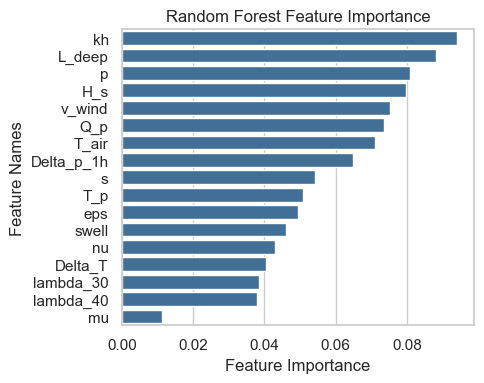

In [42]:
file_plot = f'../results/classification/RFI_{model_type}_model_randomforest_case{case}{"_undersampled" if undersample else ""}.png'
utils.plot_impurity_feature_importance(model.feature_importances_, names=X_train.columns, title="Random Forest Feature Importance", save=file_plot)

### SHAP

With SHAP we get contrastive explanations that compare the prediction with the average prediction. The global interpretations are consistent with the local explanations, since the Shapley values are the “atomic unit” of the global interpretations.

When using TreeExplainer for a Ranfom Forest model, there will be small variations between the average model prediction and the expected value from SHAP. This behaviour is explained as follows in this GitHub thread:

> It is because of how sklearn records the training samples in the tree models it builds. Random forests use a random subsample of the data to train each tree, and it is that random subsample that is used in sklearn to record the leaf sample weights in the model. Since TreeExplainer uses the recorded leaf sample weights to represent the training dataset, it will depend on the random sampling used during training. This will cause small variations like the ones you are seeing.

To get the exact same values, we have to provide a background dataset for integrating out features. This dataset has to be passed to an Independent masker, which subsamles the data. However, since the dataset is large, we cannot subsample the complete dataset and hence expect some deviation from the average model prediction.

In addition, when using SHAP to explain a classifiers output, the default value in TreeExplainer for model_output="raw", which explains the raw output of the model. For regression models, "raw" is the standard output. For classification this is the log odds ratio. We can set the model_output="probability" explaining the output of the model transformed into probability space, i.e. SHAP values now sum to the probability output of the model.

In [24]:
# run SHAP
explainer = shap.TreeExplainer(model=model, data=shap.maskers.Independent(X_train, max_samples=1000), model_output="probability")
shap_values = explainer(X_train)

# round feature values for better visualization
shap_values.data = X_train.round(4)

100%|===================| 57055/57056 [1797:14<00:01]         

In [25]:
#NOTE: the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

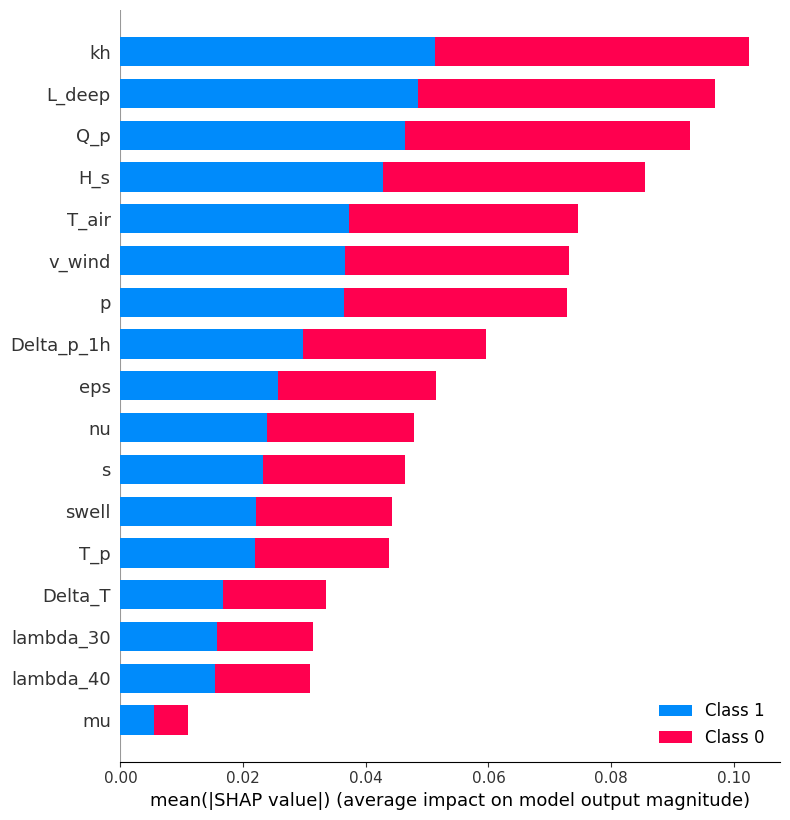

In [26]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')

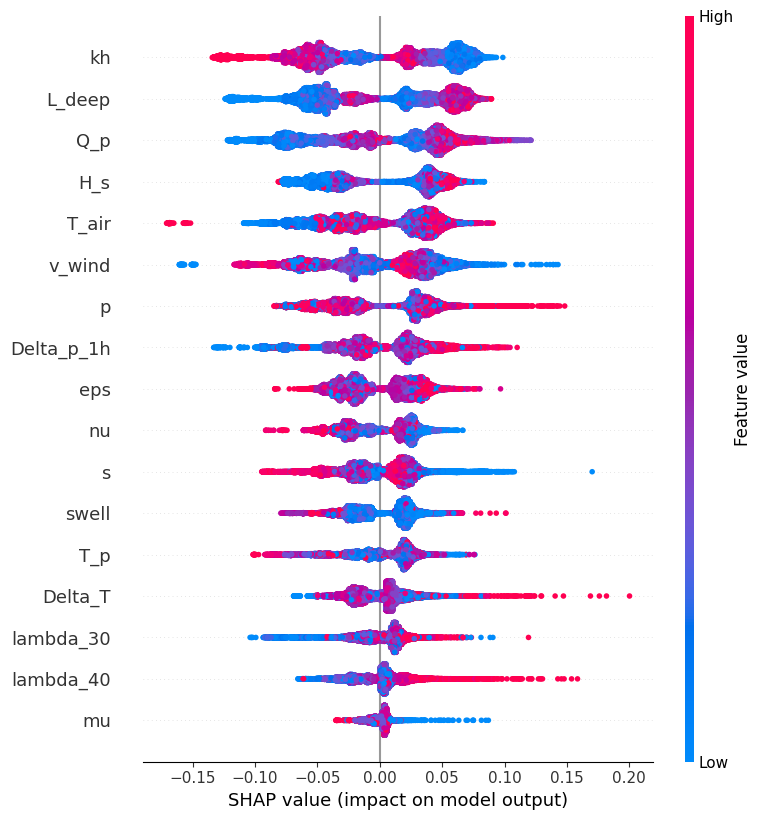

In [27]:
target_class = 0
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

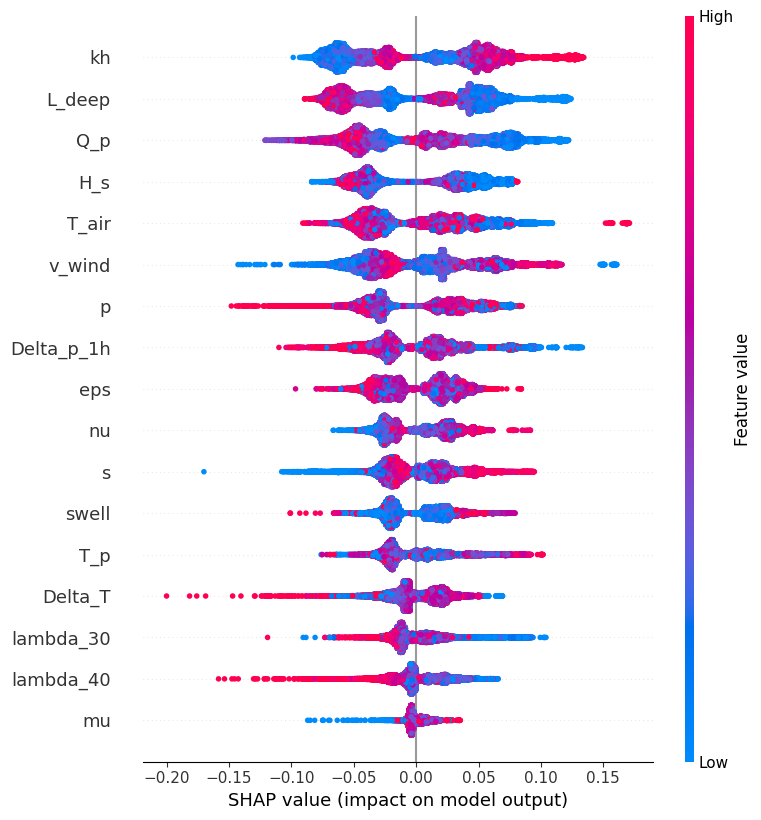

In [28]:
target_class = 1
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

### Forest-Guided Clustering 

Forest-Guided Clustering (FGC) is an explainability method for Random Forest models. Standard explainability methods (e.g. feature importance) assume independence of model features and hence, are not suited in the presence of correlated features. The Forest-Guided Clustering algorithm does not assume independence of model features, because it computes the feature importance based on subgroups of instances that follow similar decision rules within the Random Forest model. Hence, this method is well suited for cases with high correlation among model features.

Since the dataset is very large, we run the FGC optimization with memory efficient distance matrix.

In [29]:
data_fgc_class = X_train.copy()
data_fgc_class["target"] = y_train_cat
data_fgc_class["target"] = data_fgc_class["target"].map({1: 'RogueWave', 0: 'NonRogueWave'})

In [36]:
fgc = forest_guided_clustering(
    k=(2,10),
    estimator=model,
    X=data_fgc_class,
    y='target',
    clustering_distance_metric=DistanceRandomForestProximity(memory_efficient=True, dir_distance_matrix="../data/"),
    clustering_strategy=ClusteringKMedoids(method="fasterpam", init="random", max_iter=100),
    JI_bootstrap_iter=100,
    JI_bootstrap_sample_size=0.8,
    JI_discart_value=0.6,
    n_jobs=n_jobs,
    random_state=seed,
)

Using range k = (2, 10) to optimize k.


Optimizing k: 100%|██████████| 9/9 [9:32:25<00:00, 3816.22s/it]  


Optimal number of clusters k = 8

Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                                                                                           Cluster_JI
 2 0.271901    True    0.714                                                                                 {1: 0.691, 2: 0.736}
 3 0.266369    True    0.634                                                                       {1: 0.634, 2: 0.633, 3: 0.636}
 4 0.194938    True    0.687                                                             {1: 0.631, 2: 0.686, 3: 0.672, 4: 0.759}
 5 0.236255    True    0.737                                                   {1: 0.784, 2: 0.652, 3: 0.726, 4: 0.783, 5: 0.738}
 6 0.165581    True    0.727                                         {1: 0.719, 2: 0.804, 3: 0.642, 4: 0.786, 5: 0.782, 6: 0.631}
 7 0.133431    True    0.689                               {1: 0.521, 2: 0.823, 3: 0.598, 4: 0.772, 5: 0.731, 6: 0.678, 7: 0.699}
 8 0.103567    True    0

In [37]:
feature_importance = forest_guided_feature_importance(
    X=data_fgc_class,
    y='target',
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
)

100%|██████████| 17/17 [00:00<00:00, 40.05it/s]


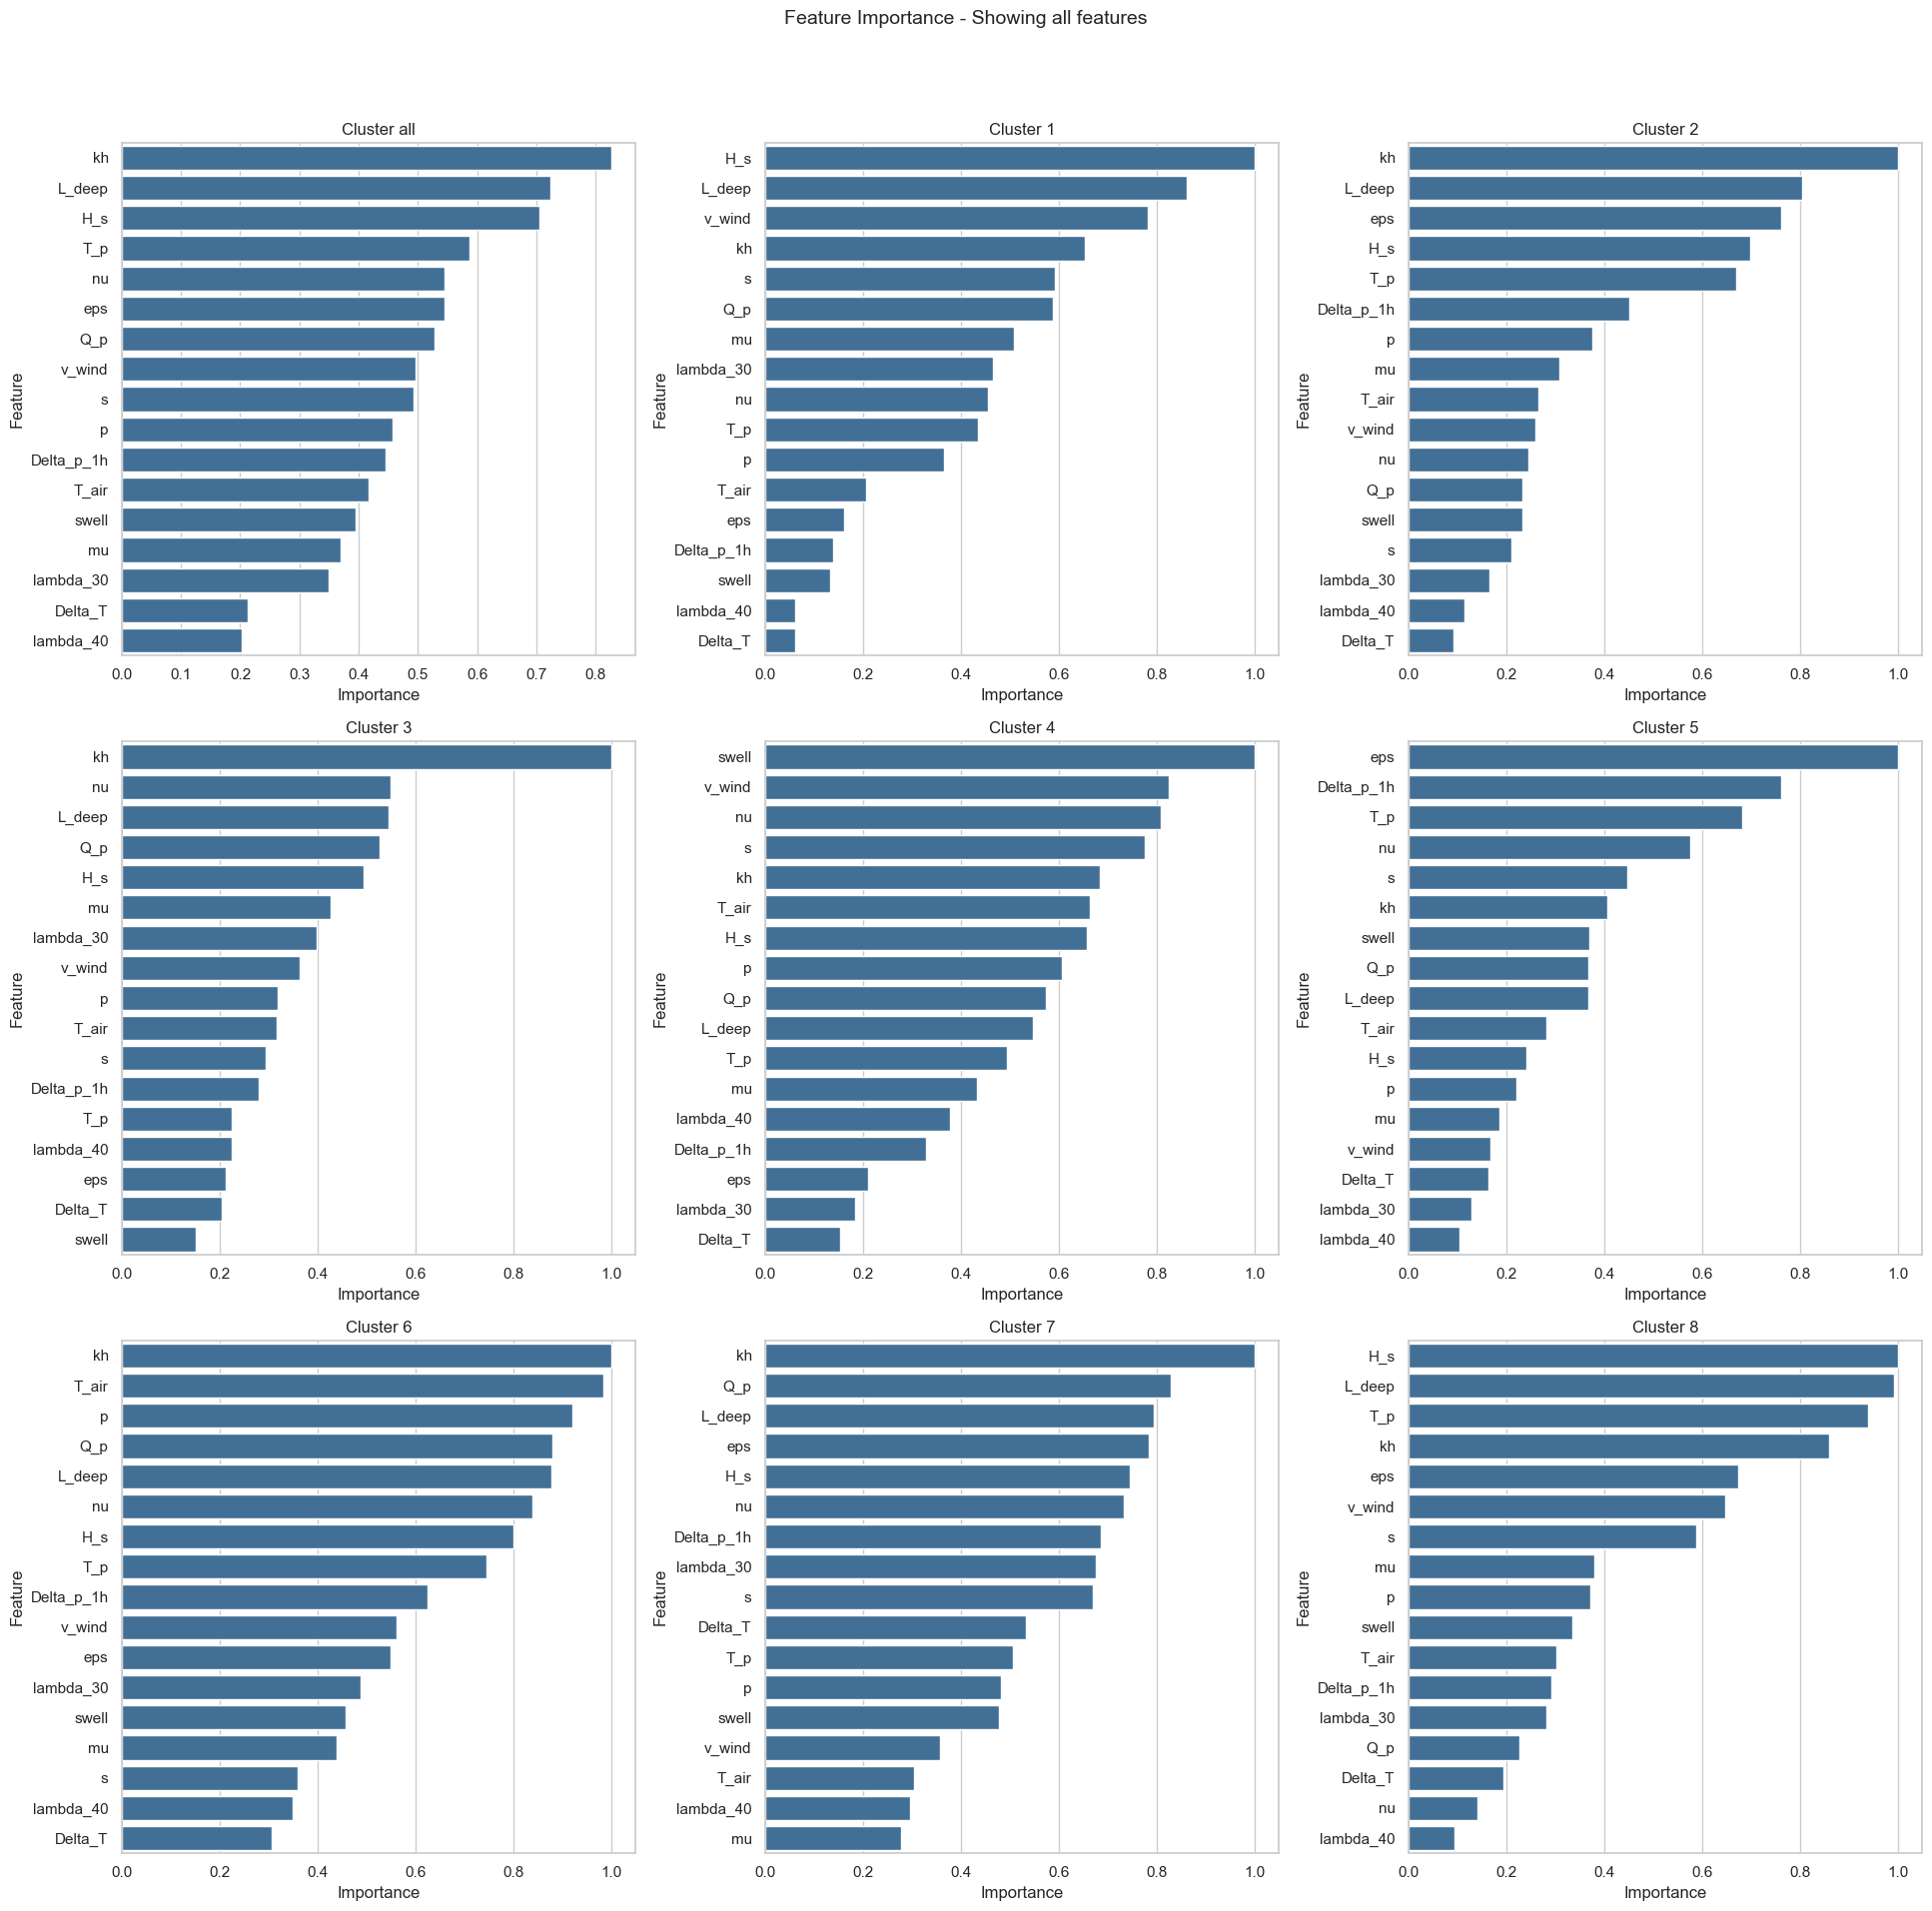

In [45]:
plot_forest_guided_feature_importance(
    feature_importance_local=feature_importance.feature_importance_local,
    feature_importance_global=feature_importance.feature_importance_global,
    num_cols=3,
    save=f'../results/classification/RFI_{model_type}_model_randomforest_case{case}{"_undersampled" if undersample else ""}',
)

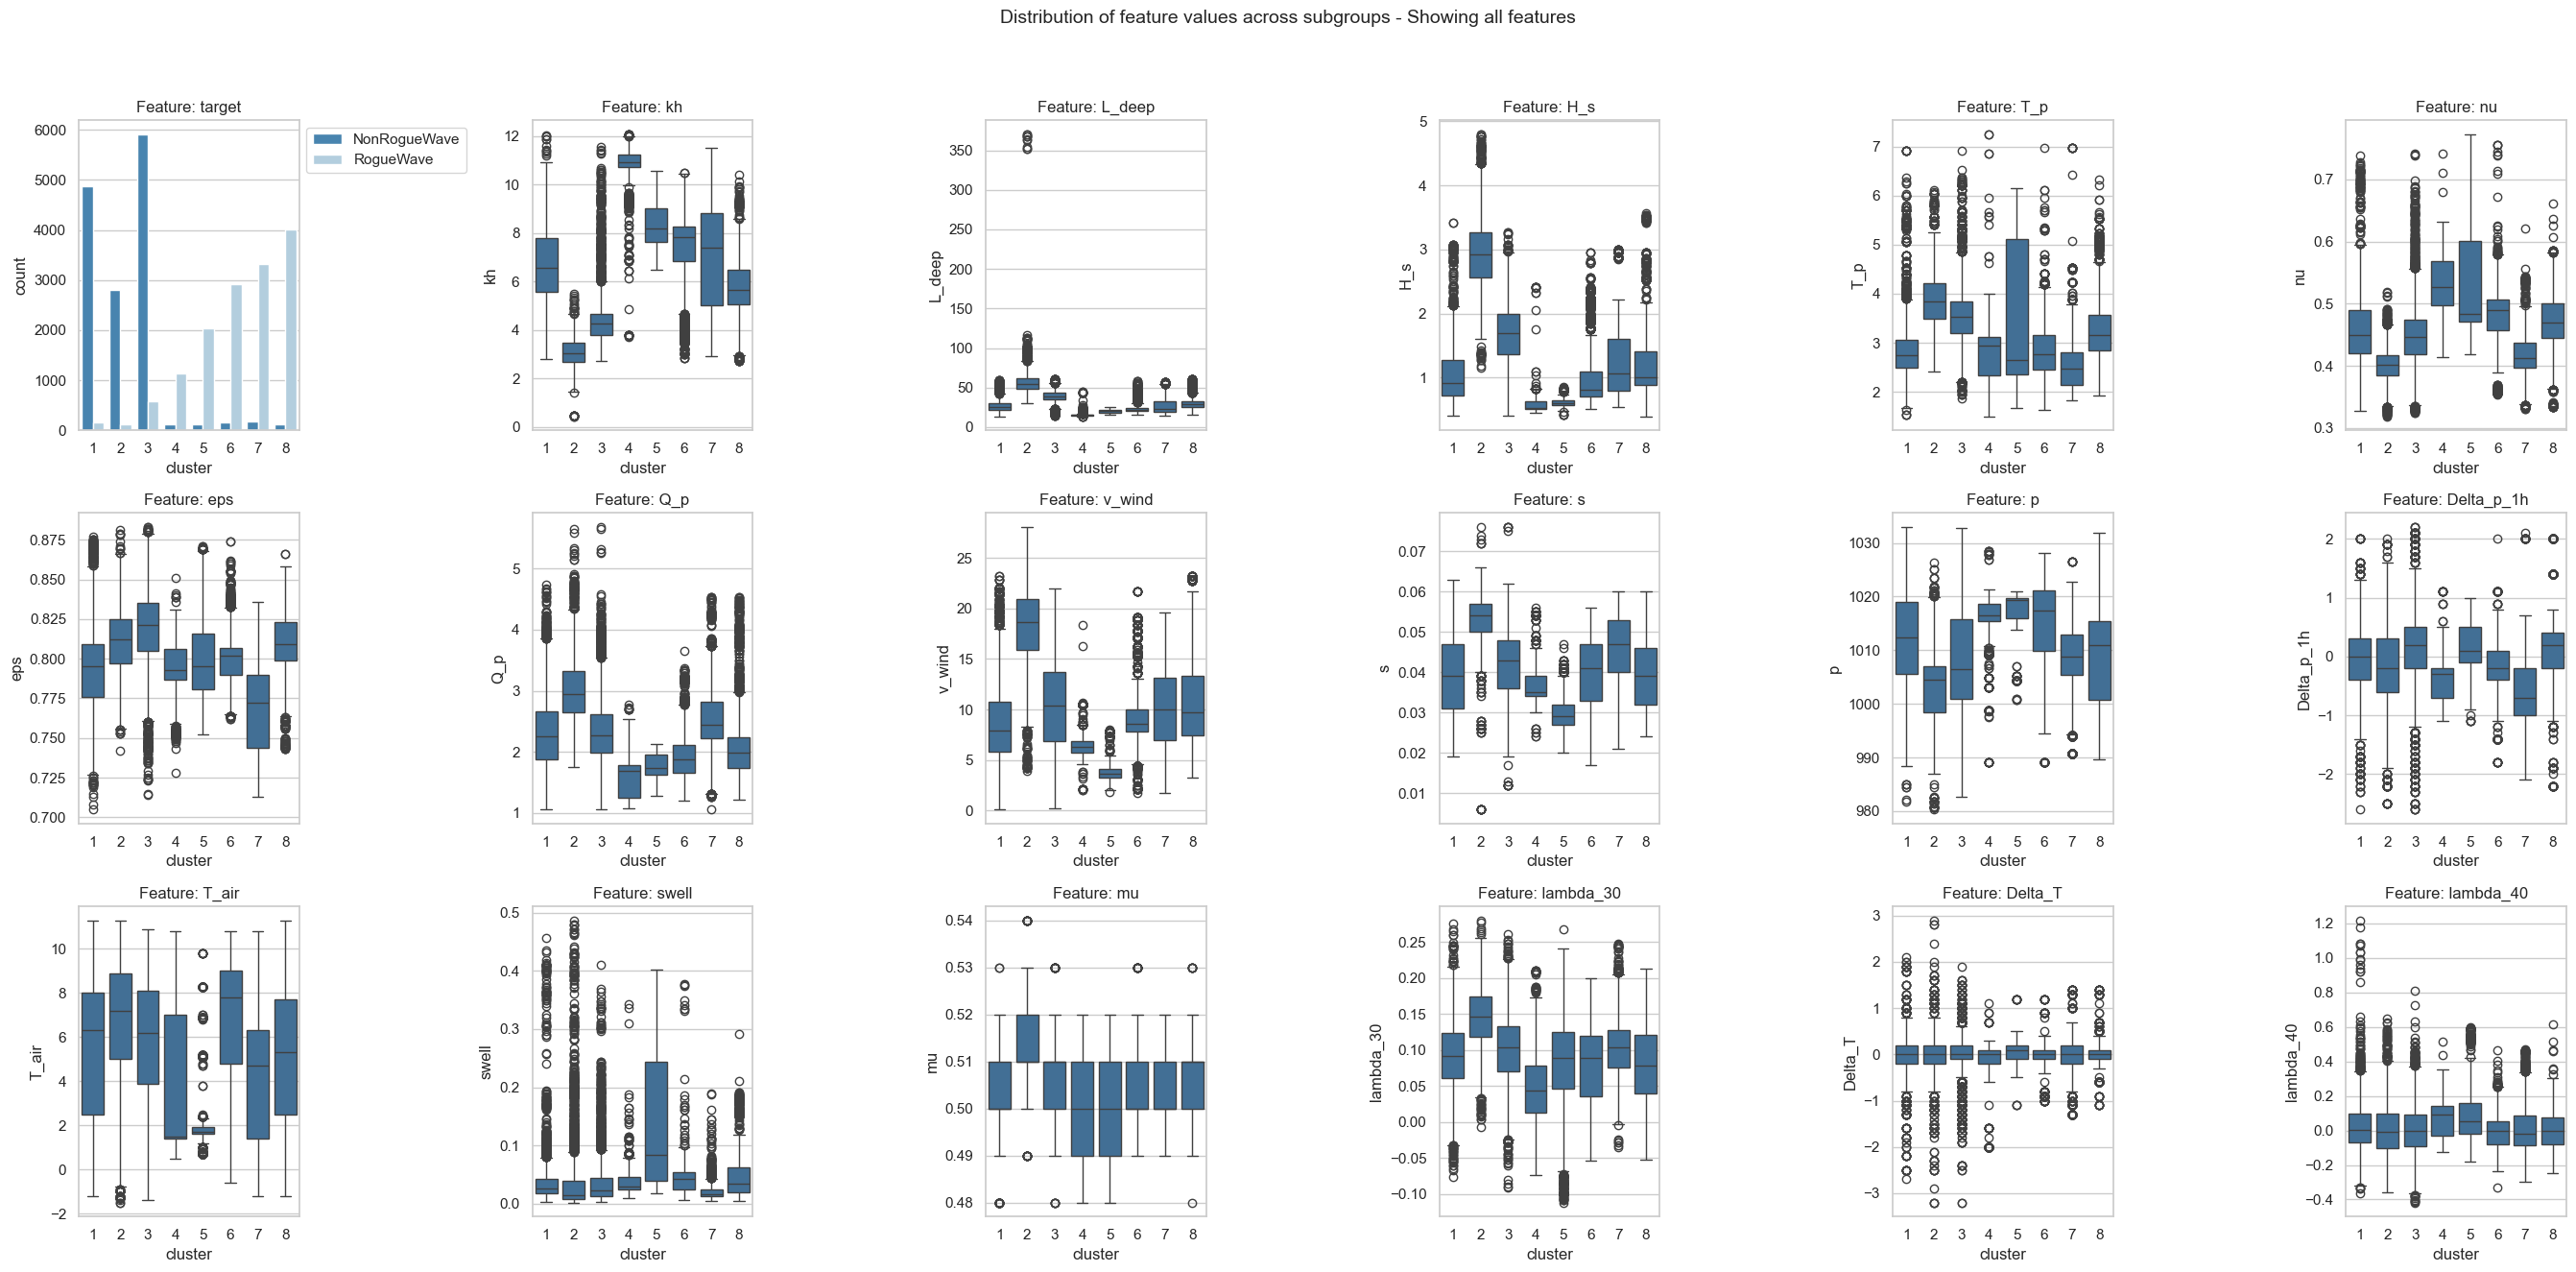

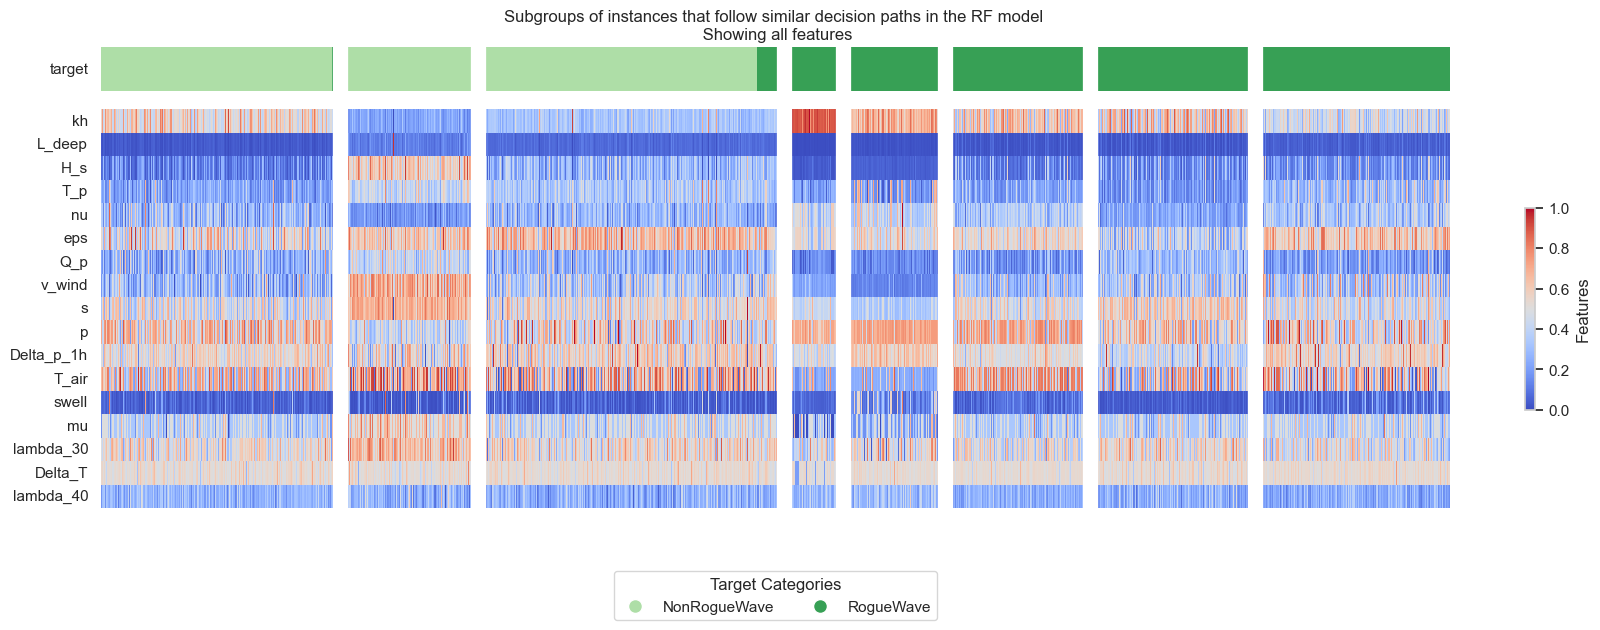

In [48]:
plot_forest_guided_decision_paths(
    data_clustering=feature_importance.data_clustering,
    model_type=fgc.model_type,
    num_cols=6,
    save=f'../results/classification/RFI_{model_type}_model_randomforest_case{case}{"_undersampled" if undersample else ""}',
)